## **Import libraries and packages**

In [ ]:
# %tensorflow_version 2.x

# import tensorflow and tensorflow.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

# import ImageDataGenerator and the related functions required for processing images
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

# import optimizers
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop

# import statements for building and loading the model
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.models import model_from_json

# import statements for callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# import statements for initlializers and regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.regularizers import l2

# import statements for one-hot encoding, model plotting
from tensorflow.keras.utils import to_categorical, plot_model

# import statements for loading ResNet50 from keras
from tensorflow.keras.applications import resnet50, xception
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

# import statements for scikit-learn
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from tensorflow.keras.layers.experimental import preprocessing

# import scipy
import scipy.misc

# import os for file access
import os 

# import glob
import glob

# import numpy, pandas
import numpy as np
import pandas as pd

# import opencv
import cv2

# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# import zipfile for unzipping the data
import zipfile

# import csv to access the csv files
import csv

# import drive to access the data from GDrive
from google.colab import drive

# import seaborn
import seaborn as sns

# import time
from time import time

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## **Load the dataset**

In [ ]:
drive.mount('/content/drive')

In [ ]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/ChIA Images_6.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
train_dir = '/tmp/ChIA Images_6/train/'
val_dir = '/tmp/ChIA Images_6/validation/'
test_dir = '/tmp/ChIA Images_6/test/'

## **Data Augmentation**

In [ ]:
training_batch_size = 16
validation_batch_size = 16
def get_images(img_size, preprocessing):

  
  train_datagen = ImageDataGenerator(rotation_range=20,
                              horizontal_flip= True,
                              height_shift_range=0.1,
                              width_shift_range=0.1,
                              shear_range=0.2,
                              zoom_range=0.2,
                              fill_mode="nearest",
                              #rescale=1./255,
                              preprocessing_function = preprocessing)
  
  datagen = ImageDataGenerator(#rescale=1./255,
                               preprocessing_function= preprocessing)
  
  train_datagen = train_datagen.flow_from_directory(train_dir,
                                            batch_size= training_batch_size,
                                            shuffle= True,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  val_datagen = datagen.flow_from_directory(val_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  test_datagen = datagen.flow_from_directory(test_dir,
                                            batch_size= validation_batch_size,
                                            shuffle= False,
                                            target_size = (img_size, img_size),
                                            classes = ['Appealing', 'Non-appealing'])
  
  return train_datagen, val_datagen, test_datagen

In [ ]:
train_datagen, val_datagen, test_datagen = get_images(299, preprocessing= xception.preprocess_input)

Found 530 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
def visualize_training(history, epochs):
  fig = plt.figure()
  
  #plt.subplot(1,2,1)
  plt.plot(history.history['accuracy']);
  plt.plot(history.history['val_accuracy'])
  plt.title("Model Accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  #plt.figsize()
  label_1 = "{:.2f}".format(history.history['accuracy'][-1])
  label_2 = "{:.2f}".format(history.history['val_accuracy'][-1])
  plt.annotate(label_1, (epochs-1,history.history['accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_2, (epochs-1,history.history['val_accuracy'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  fig = plt.figure()

  #plt.subplot(1,2,2)
  plt.plot(history.history['loss']);
  plt.plot(history.history['val_loss'])
  plt.title("Model Loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  label_3 = "{:.2f}".format(history.history['loss'][-1])
  label_4 = "{:.2f}".format(history.history['val_loss'][-1])
  plt.annotate(label_3, (epochs-1,history.history['loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.annotate(label_4, (epochs-1,history.history['val_loss'][-1]), textcoords="offset points", 
               xytext=(0,10),ha='center')
  plt.legend(['training', 'validation'], loc='upper left')

  plt.show()

In [ ]:
def print_classification_report(model, data_gen, batch_size):
  true_labels = data_gen.labels
  data_gen.reset()
  predicted_labels = model.predict(data_gen, steps = np.ceil(len(true_labels)/batch_size))
  #print(list( np.argmax(a) for a in predicted_labels), true_labels)
  print(classification_report(true_labels, list( np.argmax(a) for a in predicted_labels)))
  print("Confusion Matrix:\n ",confusion_matrix(true_labels,list( np.argmax(a) for a in predicted_labels)))

## **Build the model**

In [ ]:
xception_base = xception.Xception(weights='imagenet', include_top= False, input_shape= (299, 299, 3))

In [ ]:
xception_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
model = models.Sequential()
model.add(xception_base)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(512, activation='relu'))
# model.add(keras.layers.Dropout(0.4))
# model.add(keras.layers.Dense(512, activation='relu'))
# model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(2, activation= 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [ ]:
xception_base.trainable = False
xception_base.training = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Compile the model**

In [ ]:
lr = 1e-3
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks_list = [keras.callbacks.ModelCheckpoint(
        filepath = '/content/xception-model.h5',
        monitor = 'val_accuracy',
        verbose=1,
        save_best_only = True),
        keras.callbacks.EarlyStopping(
            monitor= 'val_accuracy',
            patience = 6,
            mode = 'max',
            verbose= 1
        )]

## **Train the model**

In [ ]:
n_epochs = 2
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps = int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                             callbacks=callbacks_list,
                             verbose=1)

Epoch 1/2
 5/33 [===>..........................] - ETA: 18s - loss: 0.9382 - accuracy: 0.5550

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (172478285 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


33/33 [==============================] - 80s 1s/step - loss: 0.7935 - accuracy: 0.6769 - val_loss: 0.4664 - val_accuracy: 0.7952

Epoch 00001: val_accuracy improved from -inf to 0.79524, saving model to /content/new-xception-model_3.h5
Epoch 2/2
33/33 [==============================] - 45s 1s/step - loss: 0.4264 - accuracy: 0.7912 - val_loss: 0.4908 - val_accuracy: 0.7857

Epoch 00002: val_accuracy did not improve from 0.79524


## **Fine tune the model**

In [ ]:
xception_base.trainable = True
set_trainable = False
for layer in xception_base.layers[:126]:
  set_trainable = False
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable= False

In [ ]:
for layer in xception_base.layers[126:]:
  if isinstance(layer, keras.layers.BatchNormalization):
    layer.trainable = False

In [ ]:
for i, layer in enumerate(xception_base.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

In [ ]:
lr = 1e-4
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
n_epochs = 40
history = model.fit(train_datagen,
                             steps_per_epoch=len(train_datagen.filenames)//training_batch_size,
                             epochs=n_epochs,
                             validation_data=val_datagen,
                             validation_steps=int(np.ceil(len(val_datagen.filenames)/validation_batch_size)),
                             callbacks=callbacks_list,
                             verbose=1)

Epoch 1/40
 6/33 [====>.........................] - ETA: 23s - loss: 0.4599 - accuracy: 0.8318

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (172478285 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


33/33 [==============================] - 48s 1s/step - loss: 0.3801 - accuracy: 0.8477 - val_loss: 0.3524 - val_accuracy: 0.8571

Epoch 00001: val_accuracy improved from 0.79524 to 0.85714, saving model to /content/new-xception-model_3.h5
Epoch 2/40
33/33 [==============================] - 44s 1s/step - loss: 0.2965 - accuracy: 0.8765 - val_loss: 0.3115 - val_accuracy: 0.8714

Epoch 00002: val_accuracy improved from 0.85714 to 0.87143, saving model to /content/new-xception-model_3.h5
Epoch 3/40
33/33 [==============================] - 44s 1s/step - loss: 0.1723 - accuracy: 0.9320 - val_loss: 0.3270 - val_accuracy: 0.8810

Epoch 00003: val_accuracy improved from 0.87143 to 0.88095, saving model to /content/new-xception-model_3.h5
Epoch 4/40
33/33 [==============================] - 44s 1s/step - loss: 0.1971 - accuracy: 0.9112 - val_loss: 0.3672 - val_accuracy: 0.8619

Epoch 00004: val_accuracy did not improve from 0.88095
Epoch 5/40
33/33 [==============================] - 44s 1s/step -

## **Visualize the training process**

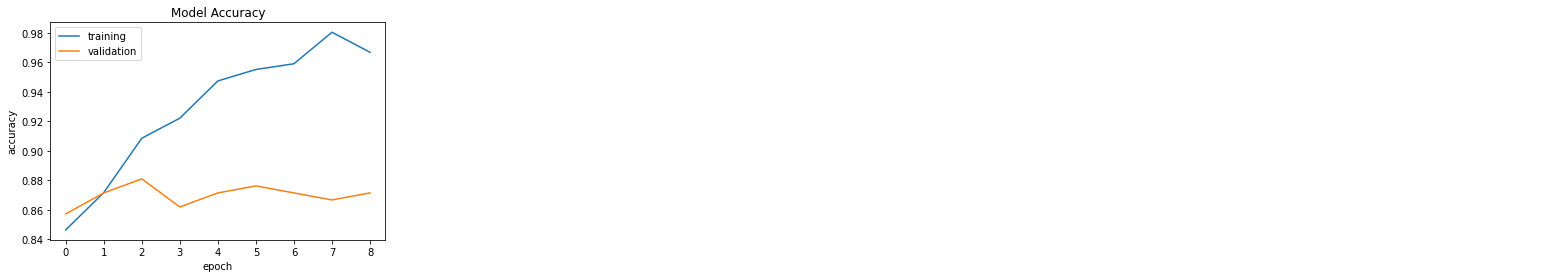

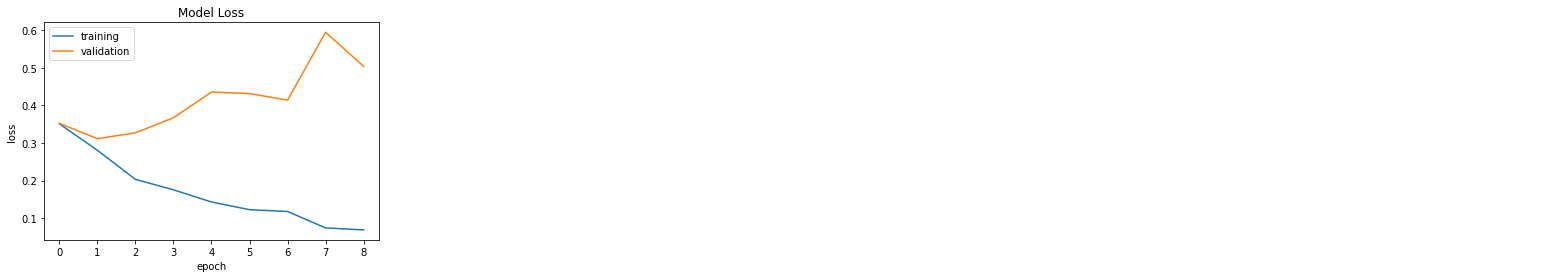

In [ ]:
visualize_training(history, n_epochs)

## **Load the saved model**

In [ ]:
loaded_model = load_model('/content/xception-model.h5')

In [ ]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 5

## **Evaluate the model**

In [ ]:
_, evaluate_datagen, _ = get_images(299, preprocessing= xception.preprocess_input)

Found 530 images belonging to 2 classes.
Found 210 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
model_result = loaded_model.evaluate(
    evaluate_datagen,
    steps= None)

14/14 [==============================] - 8s 484ms/step - loss: 0.3270 - accuracy: 0.8810


In [ ]:
test_report = loaded_model.evaluate(
    test_datagen,
    steps= None
)

6/6 [==============================] - 8s 2s/step - loss: 0.3356 - accuracy: 0.8556


## **Classification Report**

In [ ]:
print_classification_report(loaded_model, evaluate_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       140
           1       0.83      0.81      0.82        70

    accuracy                           0.88       210
   macro avg       0.87      0.86      0.87       210
weighted avg       0.88      0.88      0.88       210

Confusion Matrix:
  [[128  12]
 [ 13  57]]


In [ ]:
print_classification_report(loaded_model, test_datagen,  validation_batch_size)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        58
           1       0.81      0.78      0.79        32

    accuracy                           0.86        90
   macro avg       0.84      0.84      0.84        90
weighted avg       0.85      0.86      0.86        90

Confusion Matrix:
  [[52  6]
 [ 7 25]]
